In [20]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-09 13:45:31--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [   <=>              ]  19.68M  46.2MB/s    in 0.4s    

2025-06-09 13:45:31 (46.2 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [14]:
Groq_api_key = 'your_api_key'
client =Groq(api_key=Groq_api_key)

In [11]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [24]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('dataset/household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}

    Provide me with only python pandas code for below natural language questions, please only provide the pandas code which can provide the result when executed
    {natural_language_question}
    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="llama-3.3-70b-Versatile",
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [25]:
# Function to execute the generated pandas code and display the output

def execute_query(query,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", code_clean)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(code_clean,{'df':df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [26]:
df = load_data_set()

<ipython-input-11-d82f3dbb5b3b>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-11-d82f3dbb5b3b>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-11-d82f3dbb5b3b>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [27]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [23]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?",df)

------------------------------------------------------------------------
Python pandas Code is:

 christmas_2006 = df['2006-12-25']
hourly_power_usage = christmas_2006['Global_active_power'].resample('H').mean()
max_power_hour = hourly_power_usage.idxmax()
print("Hour of the day with the highest power usage on Christmas 2006:")
print(max_power_hour)
------------------------------------------------------------------------
Output of the code is:

Error executing code: '2006-12-25'


False

In [26]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [27]:
execute_query(" What was the average active power consumption in March 2007?",df)

------------------------------------------------------------------------
Python pandas Code is:

 average_active_power_march_2007 = df.loc[(df.index.year == 2007) & (df.index.month == 3), 'Global_active_power'].mean()
print(average_active_power_march_2007)
------------------------------------------------------------------------
Output of the code is:

1.3186270301754073


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt

# Extract day of the week from the index
df['day_of_week'] = df.index.dayofweek

# Create a new column to differentiate between weekdays and weekends
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

# Group by day type and calculate the mean energy usage
energy_usage = df.groupby('day_type')['Global_active_power'].mean()

# Plot the energy usage
energy_usage.plot(kind='bar')
plt.title('Energy Usage on Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Mean Energy Usage (kW)')
plt.show()
------------------------------------------------------------------------
Output of the code is:



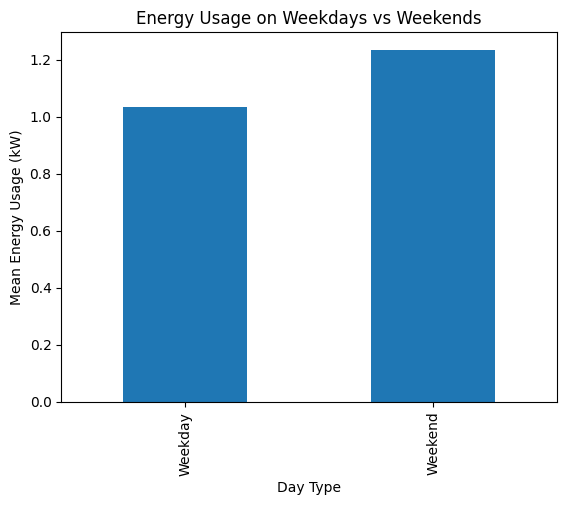

In [28]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool",df)

In [29]:
execute_query(" Find days where energy consumption exceeded 5 kWh.",df)

------------------------------------------------------------------------
Python pandas Code is:

 exceeded_days = df[df['Global_active_power'] > 5].index.date
print(exceeded_days)
------------------------------------------------------------------------
Output of the code is:

[datetime.date(2006, 12, 16) datetime.date(2006, 12, 16)
 datetime.date(2006, 12, 16) ... datetime.date(2010, 11, 24)
 datetime.date(2010, 11, 24) datetime.date(2010, 11, 25)]


------------------------------------------------------------------------
Python pandas Code is:

 import matplotlib.pyplot as plt

# Filter data for the first week of January 2007
first_week_jan_2007 = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]

# Plot the energy usage trend
plt.figure(figsize=(10,6))
plt.plot(first_week_jan_2007.index, first_week_jan_2007['Global_active_power'])
plt.title('Energy Usage Trend for the First Week of January 2007')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.grid(True)
plt.show()
------------------------------------------------------------------------
Output of the code is:



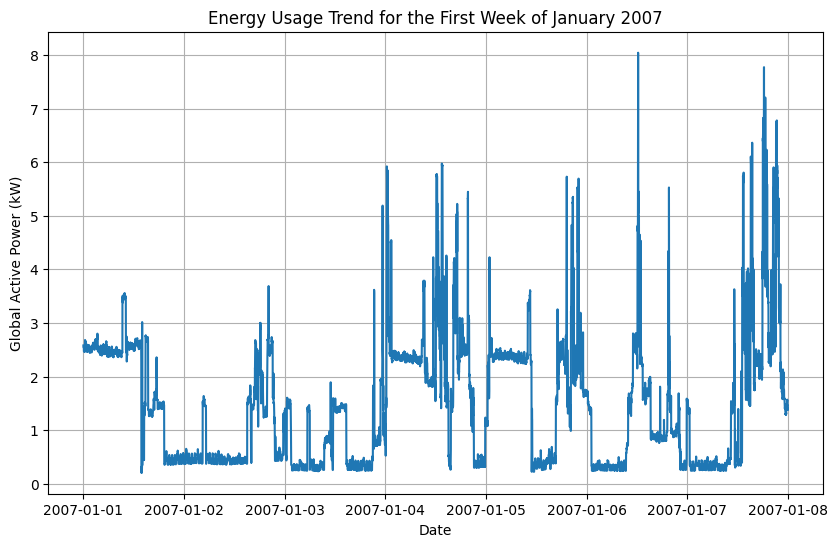

In [30]:
execute_query("Plot the energy usage trend for the first week of January 2007.",df)

------------------------------------------------------------------------
Python pandas Code is:

 import matplotlib.pyplot as plt

# Filter data for the first week of January 2007
first_week_jan_2007 = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]

# Aggregate data by day
daily_energy_usage = first_week_jan_2007['Global_active_power'].resample('D').mean()

# Plot the energy usage trend
plt.figure(figsize=(10,6))
plt.plot(daily_energy_usage)
plt.title('Energy Usage Trend for the First Week of January 2007')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.grid(True)
plt.show()
------------------------------------------------------------------------
Output of the code is:



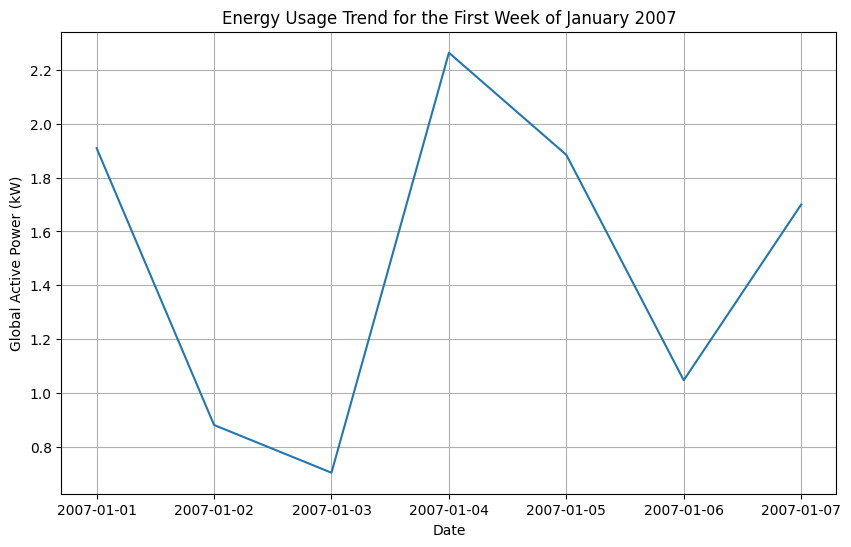

In [31]:
execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day",df)

In [34]:
execute_query("Find the average voltage for each day of the first week of February 2007",df)

------------------------------------------------------------------------
Python pandas Code is:

 df['date'] = df.index.date
df_feb_2007 = df[(df['date'].dt.month == 2) & (df['date'].dt.year == 2007)]
df_first_week_feb_2007 = df_feb_2007[(df_feb_2007['date'].dt.day <= 7)]
average_voltage = df_first_week_feb_2007.groupby(df_first_week_feb_2007.index.date)['Voltage'].mean()
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:

Error executing code: Can only use .dt accessor with datetimelike values


False

In [35]:
execute_query("What is the correlation between global active power and sub-metering values?.",df)

------------------------------------------------------------------------
Python pandas Code is:

 correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
print(correlation)
------------------------------------------------------------------------
Output of the code is:

                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3             1.000000  


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation between global active power and sub-metering values
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()

# Print correlation matrix
print(correlation)

# Visualize correlation using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation between Global Active Power and Sub-metering Values')
plt.show()

# Visualize correlation using scatter plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x='Global_active_power', y='Sub_metering_1', data=df, ax=axs[0])
sns.scatterplot(x='Global_active_power', y='Sub_metering_2', data=df, ax=axs[1])
sns.scatterplot(x='Global_active_power', y='Sub_metering_3', data=df, ax=axs[2])
axs[0].set_title('Global Active Power vs Sub-

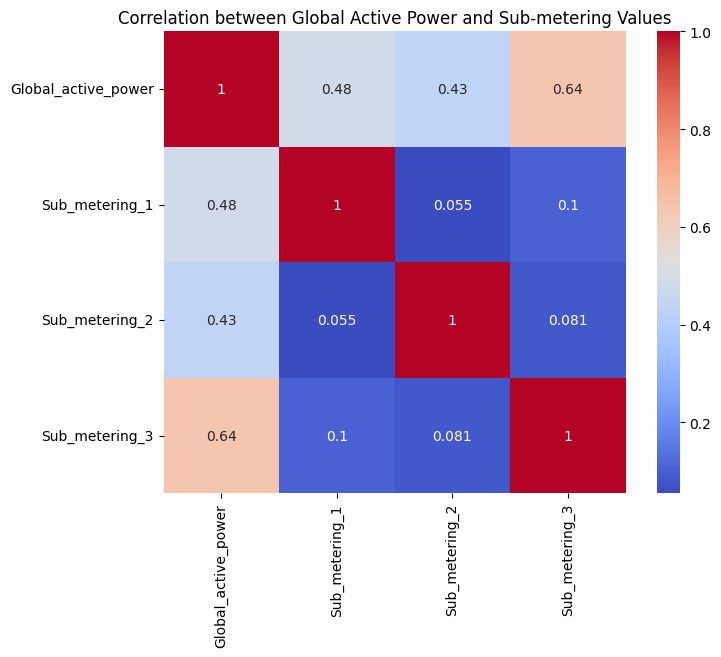

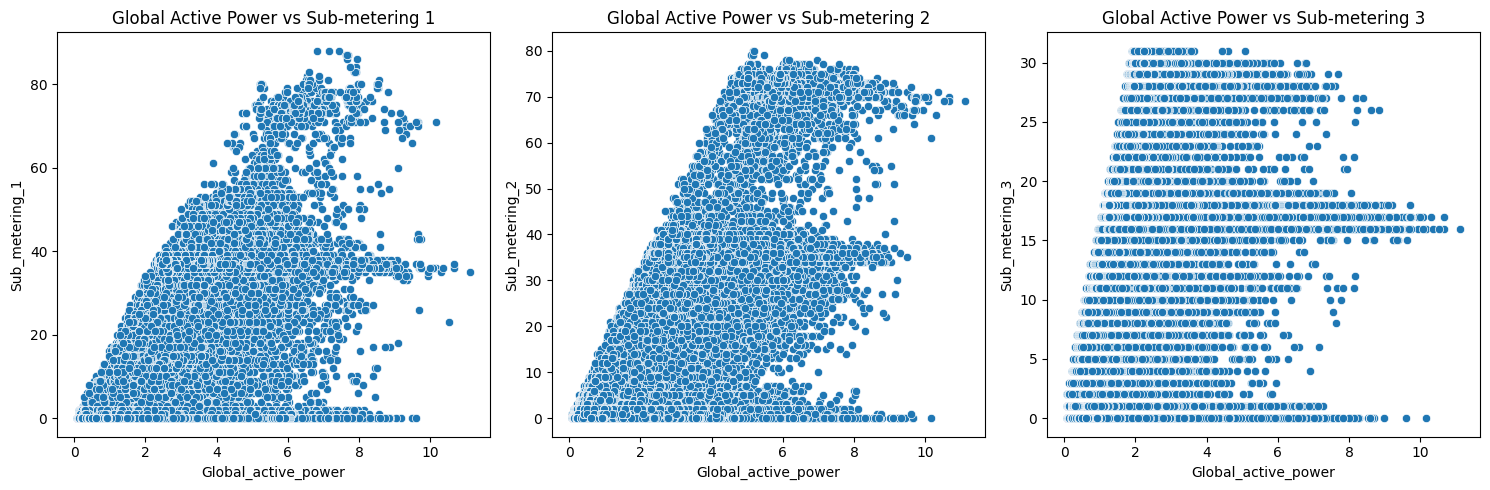

In [36]:
execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization",df)

In [40]:
execute_query("Find the average voltage for each day of the first week of February 2008",df)

------------------------------------------------------------------------
Python pandas Code is:

 first_week_feb = df['2008-02-01':'2008-02-07']
daily_voltage = first_week_feb['Voltage'].resample('D').mean()
print("Average voltage for each day of the first week of February 2008:")
print(daily_voltage)
------------------------------------------------------------------------
Output of the code is:

Average voltage for each day of the first week of February 2008:
datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


In [29]:
execute_query("Find days where energy consumption exceeded 2 kWh in 2008",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for 2008
df_2008 = df[df.index.year == 2008]

# Calculate daily energy consumption
daily_energy_consumption = df_2008['Global_active_power'].resample('D').sum() / 1000  # Convert to kWh

# Find days where energy consumption exceeded 2 kWh
days_exceeded_2kwh = daily_energy_consumption[daily_energy_consumption > 2]

print(days_exceeded_2kwh)
------------------------------------------------------------------------
Output of the code is:

datetime
2008-01-01    2.759738
2008-01-04    2.291852
2008-01-05    2.183248
2008-01-08    2.043550
2008-01-12    2.871408
                ...   
2008-12-17    2.098786
2008-12-20    2.242502
2008-12-21    2.643610
2008-12-22    2.015808
2008-12-27    2.972164
Name: Global_active_power, Length: 74, dtype: float64


In [28]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd

# Filter data for Christmas 2006
christmas_2006 = df[(df.index.year == 2006) & (df.index.month == 12) & (df.index.day == 25)]

# Group by hour and calculate mean power usage
hourly_power_usage = christmas_2006['Global_active_power'].groupby(christmas_2006.index.hour).mean()

# Find the hour with the highest power usage
max_power_hour = hourly_power_usage.idxmax()

print(max_power_hour)
------------------------------------------------------------------------
Output of the code is:

22


Loading dataset...
Dataset loaded successfully.
Enter your natural language question (or type 'exit' to quit): What hour of the day had the highest power usage on Christmas 2008?
------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd

# Filter data for Christmas 2008
christmas_2008 = df[(df.index.year == 2008) & (df.index.month == 12) & (df.index.day == 25)]

# Group by hour and calculate mean power usage
hourly_power_usage = christmas_2008['Global_active_power'].groupby(christmas_2008.index.hour).mean()

# Find the hour with the highest power usage
max_power_hour = hourly_power_usage.idxmax()

print(max_power_hour)
------------------------------------------------------------------------
Output of the code is:

0

Query executed successfully.
------------------------------------------------------------------------

Enter your natural language question (or type 'exit' to quit): What hour of the day had the highest power usag

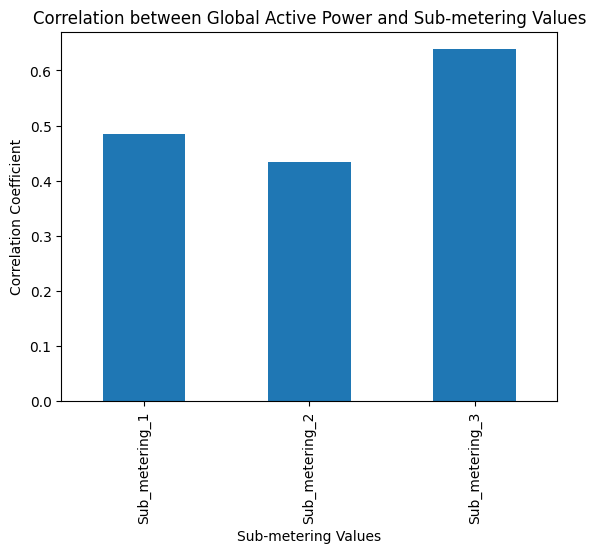


Query executed successfully.
------------------------------------------------------------------------

Enter your natural language question (or type 'exit' to quit): exit
------------------------------------------------------------------------
Python pandas Code is:

 There are no natural language questions provided to write pandas code for. Please provide the questions.
------------------------------------------------------------------------
Output of the code is:

Error executing code: invalid syntax (<string>, line 1)

Query executed successfully.
------------------------------------------------------------------------



KeyboardInterrupt: Interrupted by user

In [30]:
print("Loading dataset...")

if df is not None:
  print("Dataset loaded successfully.")

  while True:
      query = input("Enter your natural language question (or type 'exit' to quit): ")
      if query.lower() == 'exit':
          quit()
      execute_query(query, df)
      print("\nQuery executed successfully.\n------------------------------------------------------------------------\n")
else:
  print("Failed to load dataset. Please check the file path and format.")